In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib
from scipy.spatial import cKDTree

# Step 1: Generate a set of 2D points
np.random.seed(0)  # For reproducibility
num_points = 10000# You can adjust the number of points as needed
cube_length = 20
voxel_resolution = 2**8
points = np.random.uniform(-10, 10, size=(num_points, 2))
masses = np.random.uniform(1, 10, size=(1,num_points))
velocities = np.random.uniform(0, 10, size=(1, num_points))

points[0] = np.array([1,1])
points[1] = np.array([2,2])
points[2] = np.array([1.2,1.1])
# points = np.array([[2,8],[-2,-8],[0,0]])


bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers]) # kpc


xx = np.meshgrid(bins, bins)[0]
yy = np.meshgrid(bins, bins)[1]

xx_c = np.meshgrid(bin_centers,bin_centers)[0]
yy_c = np.meshgrid(bin_centers,bin_centers)[1]

# voxel_centers 

grid_c = np.dstack(np.array([xx_c,yy_c])).reshape(-1,2)


l = len(bins)
grid_points_1 = np.vstack((xx[0:l-1,1:  l].ravel(), yy[0:l-1,1:  l].ravel())).T
grid_points_2 = np.vstack((xx[0:l-1,0:l-1].ravel(), yy[0:l-1,0:l-1].ravel())).T
grid_points_3 = np.vstack((xx[1:  l,0:l-1].ravel(), yy[1:  l,0:l-1].ravel())).T
grid_points_4 = np.vstack((xx[1:  l,1:  l].ravel(), yy[1:  l,1:  l].ravel())).T

voxel_vertices = np.array([grid_points_1 ,grid_points_2,grid_points_3,grid_points_4])
voxel_vertices = np.swapaxes(voxel_vertices, 0, 1)

In [63]:
binned_points, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_points = binned_points[0]

select_binned_points = np.reshape(binned_points,(voxel_resolution**2,))!=0


binned_velocity, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      velocities*masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_velocity = binned_velocity[0]
binned_velocity[binned_velocity!=0] = binned_velocity[binned_velocity!=0] / binned_points[binned_velocity!=0]

In [30]:
np.shape(binned_velocity)

(1, 256, 256)

In [4]:
# t0 = timeit.default_timer()
# tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
# indices = tree_points.query(grid_c)[1]
# tf = timeit.default_timer()
# print(tf - t0)

In [5]:
# t0 = timeit.default_timer()
# grid_ids = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)
# tf = timeit.default_timer()
# print(tf - t0)

In [64]:
non_empty_points = binned_points!=0

grid_ids = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)

# tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
# grid_ids = tree_points.query(grid_c)[1]

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**2)
quantity = np.reshape(binned_points, voxel_resolution**2)
quantity_v = np.reshape(binned_velocity, voxel_resolution**2)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution))

In [65]:
grid_ids_1 = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)
tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
grid_ids_2 = tree_points.query(grid_c, workers=-1)[1]

In [66]:
voronoied_result_1 = quantity[non_empty_points_reshaped][grid_ids_1] / np.bincount(grid_ids_1)[grid_ids_1]
voronoied_result_1 = voronoied_result_1.reshape((voxel_resolution, voxel_resolution))

voronoied_result_2 = quantity[non_empty_points_reshaped][grid_ids_2] / np.bincount(grid_ids_2)[grid_ids_2]
voronoied_result_2 = voronoied_result_2.reshape((voxel_resolution, voxel_resolution))

voronoied_result_1_v = quantity_v[non_empty_points_reshaped][grid_ids_1] #/ np.bincount(grid_ids_1)[grid_ids_1]
voronoied_result_1_v = voronoied_result_1_v.reshape((voxel_resolution, voxel_resolution))

voronoied_result_2_v = quantity_v[non_empty_points_reshaped][grid_ids_2] #/ np.bincount(grid_ids_2)[grid_ids_2]
voronoied_result_2_v = voronoied_result_2_v.reshape((voxel_resolution, voxel_resolution))

In [69]:
print(f"{np.sum(voronoied_result_1)}\n{np.sum(voronoied_result_2)}\n{np.sum(masses)}")
print(f"{(grid_ids_1 - grid_ids_2 != 0).sum()}/{len(grid_ids_1)} = {(grid_ids_1 - grid_ids_2 != 0).sum()/len(grid_ids_1)*100}%")

55063.80124007457
55063.80124007457
55063.80124007457
6005/65536 = 9.16290283203125%


In [68]:
print(f"{np.sum(masses*velocities)/np.sum(masses)}")
print(f"{np.sum(voronoied_result_1*voronoied_result_1_v)/np.sum(voronoied_result_1)}")
print(f"{np.sum(voronoied_result_2*voronoied_result_2_v)/np.sum(voronoied_result_2)}")

4.99362184319086
4.99362184319086
4.99362184319086


In [140]:
np.sum(masses)

55063.80124007457

In [16]:
[True, True, True].count

<function list.count(value, /)>

In [147]:
grid_ids_2 - grid_ids_1

array([0, 0, 0, ..., 0, 0, 0])

In [85]:
# grid_ids_2 - grid_ids_1 == grid_ids_2 - grid_ids

In [66]:
points = np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()

In [67]:
points[:,0]

array([ 1.875,  6.875, -8.125,  3.125,  4.375, -8.125,  4.375,  9.375,
       -6.875, -3.125, -8.125, -6.875,  5.625, -3.125, -1.875,  3.125,
       -5.625,  1.875,  5.625,  8.125, -8.125, -1.875,  0.625, -9.375,
       -4.375, -0.625,  1.875,  8.125, -6.875, -4.375,  3.125, -9.375,
        0.625,  6.875, -9.375, -8.125, -8.125, -1.875, -0.625,  1.875,
        3.125,  5.625])

In [70]:
grid_ids = np.empty(256)
for grid_id, grid_point in enumerate(grid_c):
    dist = np.sqrt((grid_point[0]-points[:,0])**2 + (grid_point[1]-points[:,1])**2)
    grid_ids[grid_id] = np.argmin(dist)

grid_ids

array([ 2.,  2.,  2.,  2.,  2.,  9.,  0.,  0.,  0.,  0.,  0.,  4.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  9.,  9.,  9.,  0.,  0.,  0.,
        3.,  4.,  4.,  1.,  1.,  7.,  5.,  5.,  5.,  8.,  9.,  9.,  9.,
        9.,  0.,  3.,  3.,  6.,  6.,  1.,  7.,  7.,  5.,  5.,  8.,  8.,
        9.,  9.,  9.,  9.,  3.,  3.,  6.,  6., 12., 12.,  7.,  7., 10.,
       10., 11., 11.,  9.,  9., 14., 14., 14., 15., 15., 12., 12., 12.,
       12.,  7., 10., 10., 11., 11., 13., 13., 14., 14., 14., 15., 15.,
       15., 12., 12., 19., 19., 10., 10., 16., 16., 13., 13., 14., 14.,
       17., 17., 15., 15., 18., 18., 19., 19., 20., 20., 16., 16., 16.,
       21., 21., 21., 17., 17., 17., 18., 18., 18., 19., 19., 20., 20.,
       20., 16., 24., 21., 21., 21., 22., 17., 17., 18., 18., 18., 19.,
       19., 23., 20., 28., 24., 24., 24., 21., 25., 22., 26., 26., 30.,
       18., 27., 27., 27., 23., 28., 28., 28., 29., 29., 25., 25., 25.,
       26., 30., 30., 30., 27., 27., 27., 31., 31., 28., 28., 29

In [49]:
grid_ids_1 - grid_ids_2

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0, -5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -4, -4,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0, -5, -9,  0,  0, -9, -8, -8,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -4,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1

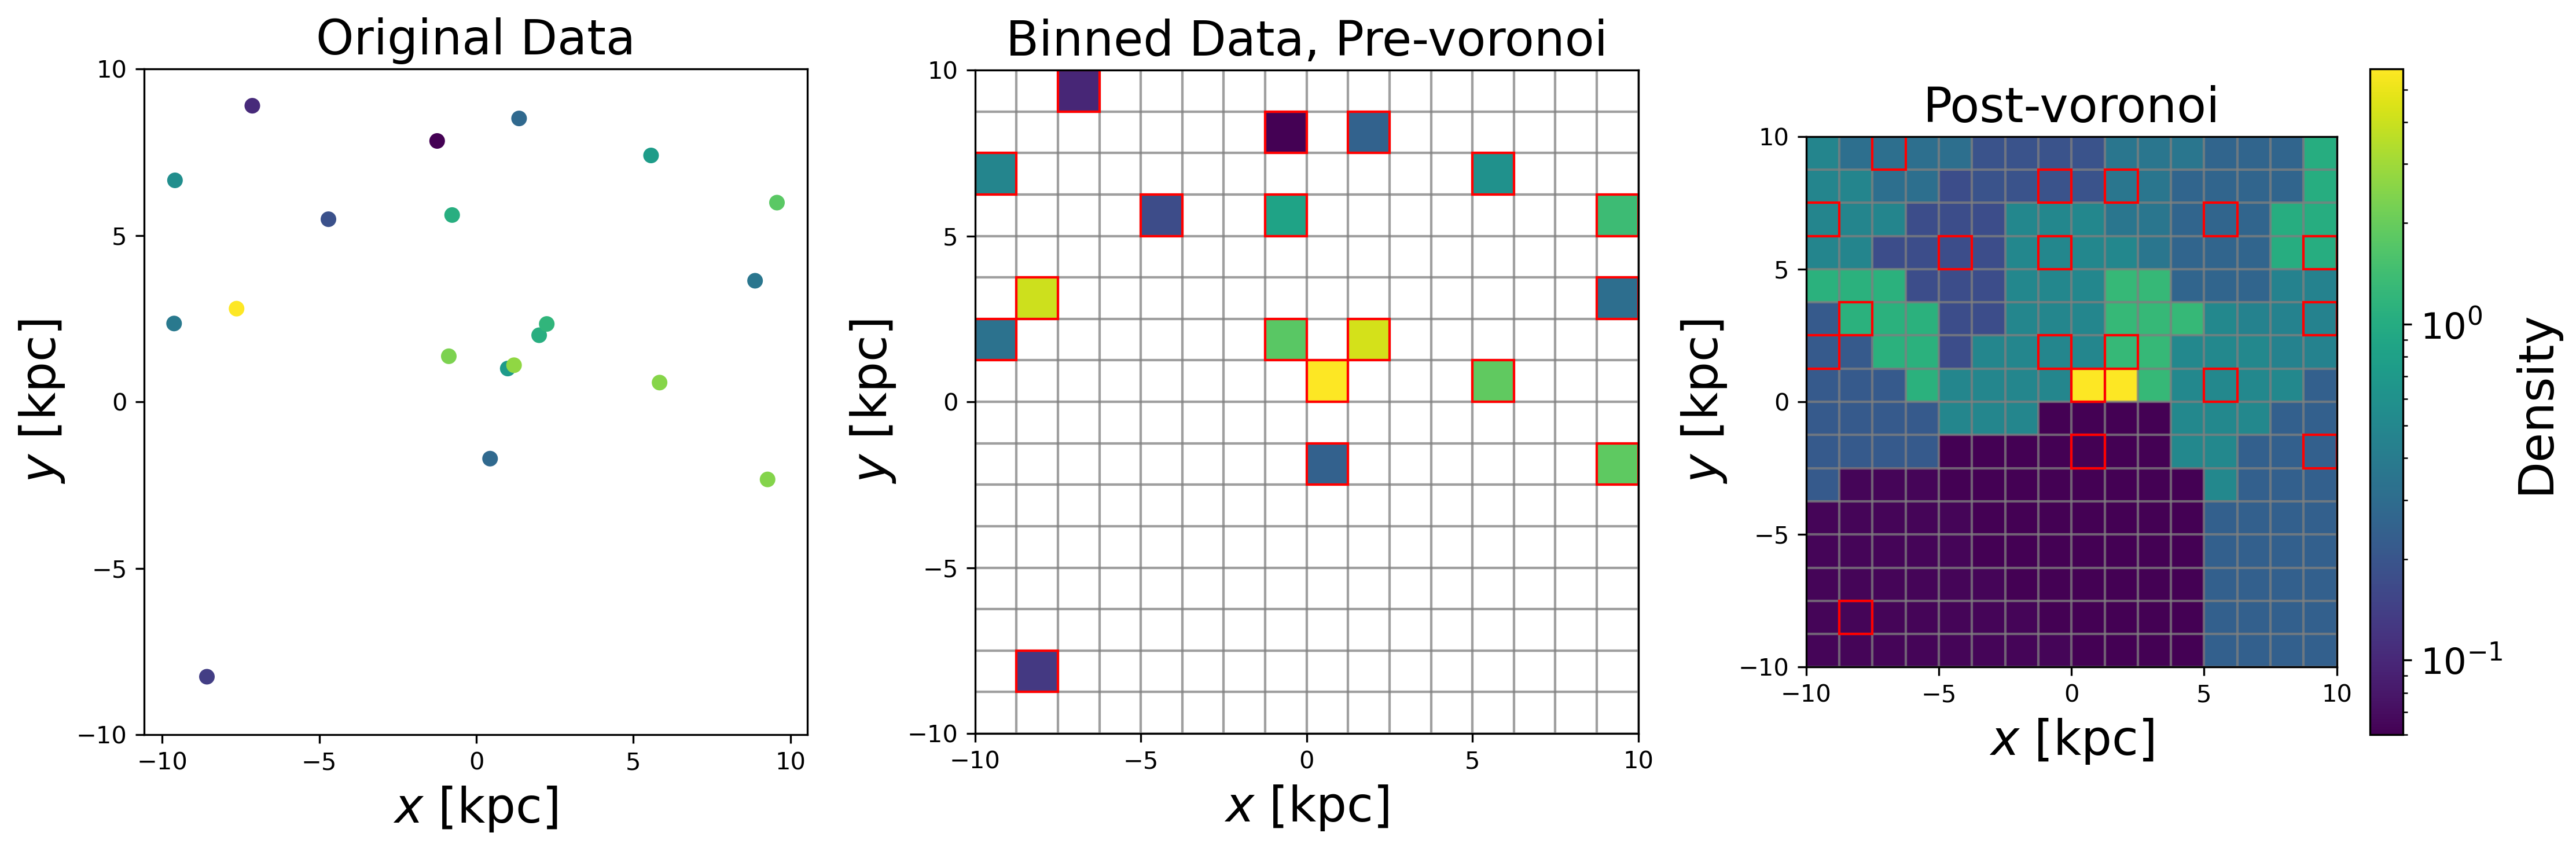

In [98]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Subplot 1: Original Data
sc = axs[0].scatter(points[:, 0], points[:, 1], c=masses, cmap='viridis', s=30, norm=matplotlib.colors.LogNorm())
# cbar = plt.colorbar(sc, ax=axs[0])
axs[0].set_title("Original Data", size=20)
axs[0].set_xlabel('$x$ [kpc]', size=20)
axs[0].set_ylabel('$y$ [kpc]', size=20)
axs[0].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[0].set_yticks(np.array([-10, -5, 0, 5, 10]))
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label("Mass", fontsize=20)

# Subplot 2: Binned Data, Pre-voronoi
axs[1].imshow(binned_points.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[1].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[1].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
axs[1].set_title("Binned Data, Pre-voronoi", size=20)
axs[1].set_xlabel('$x$ [kpc]', size=20)
axs[1].set_ylabel('$y$ [kpc]', size=20)
axs[1].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[1].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Subplot 3: Post-voronoi
im = axs[2].imshow(voronoied_result.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[2].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[2].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
cbar = plt.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Density", fontsize=20)
axs[2].set_title("Post-voronoi", size=20)
axs[2].set_xlabel('$x$ [kpc]', size=20)
axs[2].set_ylabel('$y$ [kpc]', size=20)
axs[2].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[2].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Adjust layout
plt.tight_layout()

plt.savefig("../visuals/demo-argmin.png", bbox_inches='tight')

# Show the plot
plt.show()

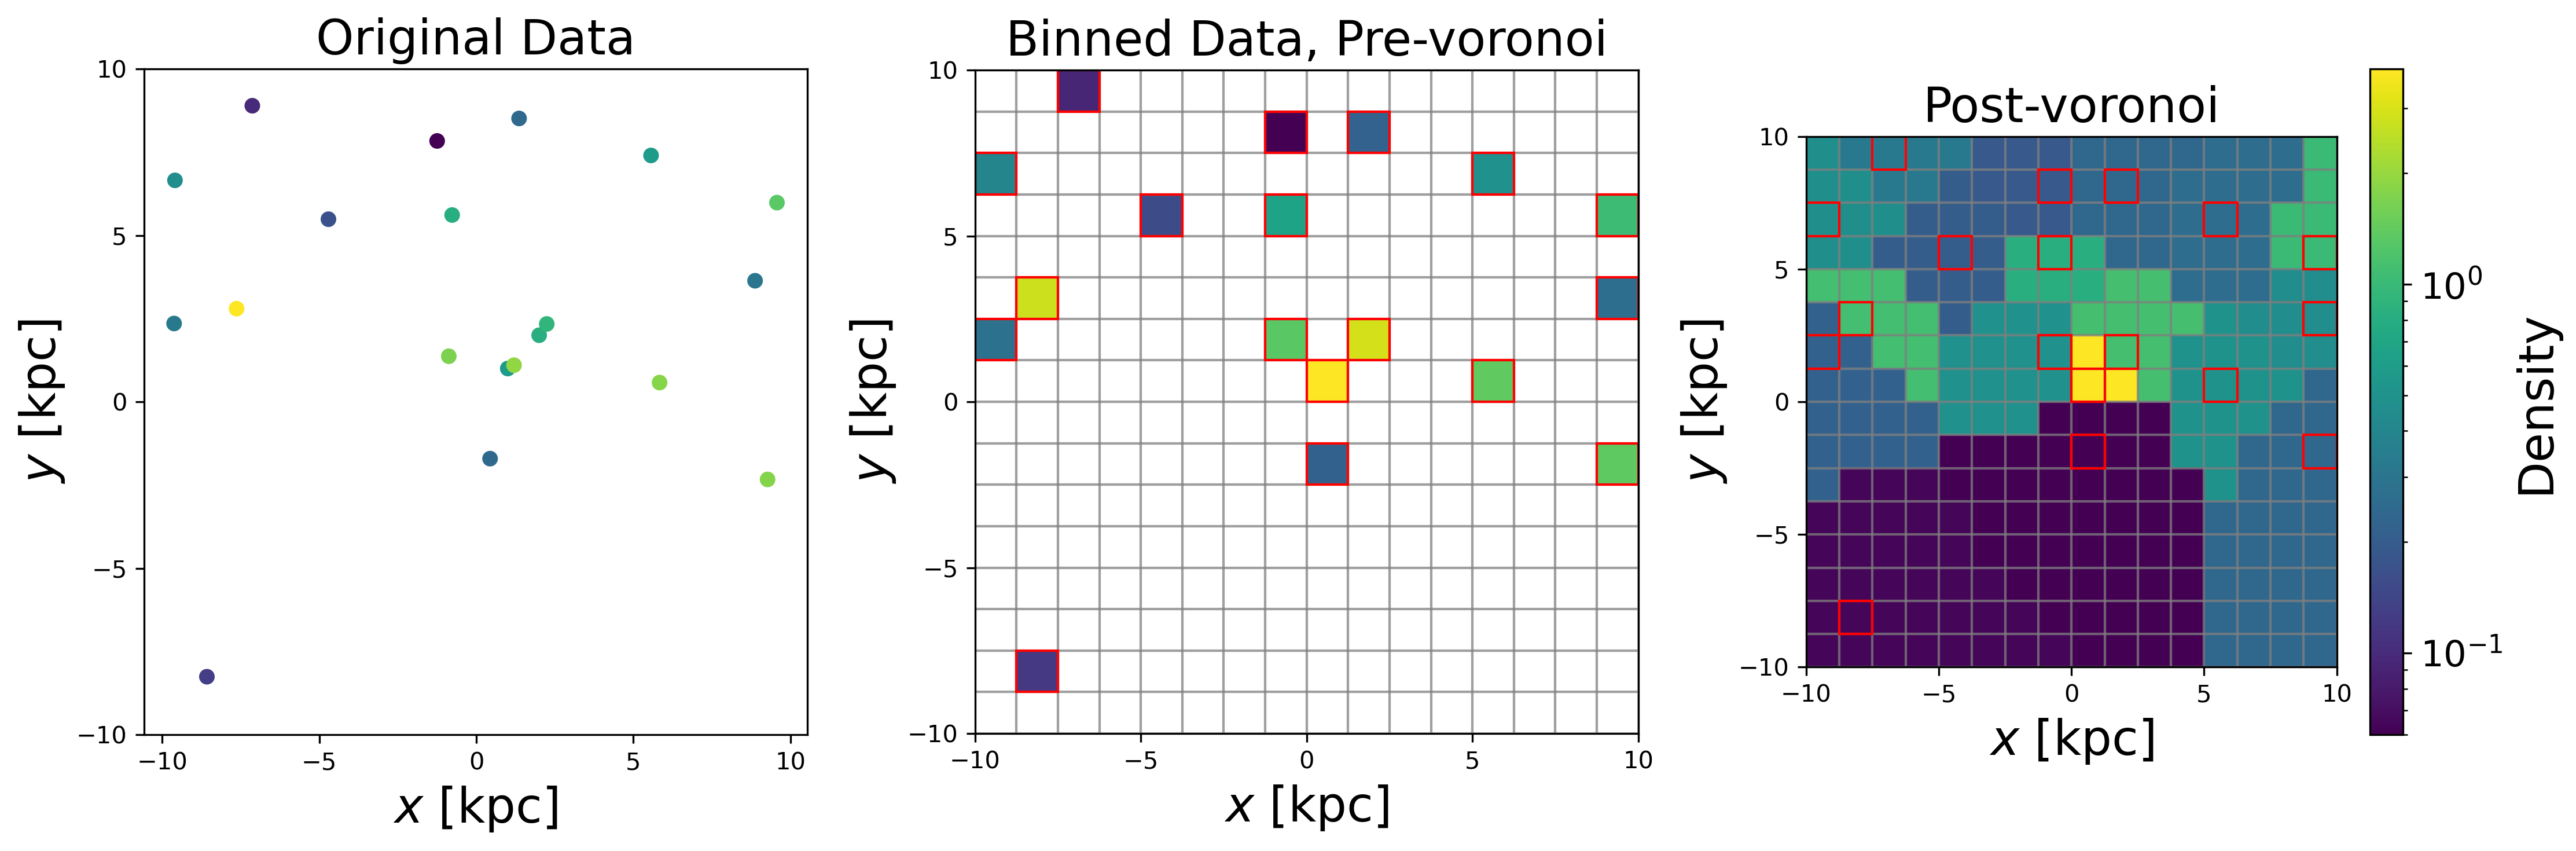

In [101]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Subplot 1: Original Data
sc = axs[0].scatter(points[:, 0], points[:, 1], c=masses, cmap='viridis', s=30, norm=matplotlib.colors.LogNorm())
# cbar = plt.colorbar(sc, ax=axs[0])
axs[0].set_title("Original Data", size=20)
axs[0].set_xlabel('$x$ [kpc]', size=20)
axs[0].set_ylabel('$y$ [kpc]', size=20)
axs[0].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[0].set_yticks(np.array([-10, -5, 0, 5, 10]))
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label("Mass", fontsize=20)

# Subplot 2: Binned Data, Pre-voronoi
axs[1].imshow(binned_points.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[1].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[1].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
axs[1].set_title("Binned Data, Pre-voronoi", size=20)
axs[1].set_xlabel('$x$ [kpc]', size=20)
axs[1].set_ylabel('$y$ [kpc]', size=20)
axs[1].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[1].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Subplot 3: Post-voronoi
im = axs[2].imshow(voronoied_result.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[2].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[2].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
cbar = plt.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Density", fontsize=20)
axs[2].set_title("Post-voronoi", size=20)
axs[2].set_xlabel('$x$ [kpc]', size=20)
axs[2].set_ylabel('$y$ [kpc]', size=20)
axs[2].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[2].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Adjust layout
plt.tight_layout()


plt.savefig("../visuals/demo-cKDTree.png", bbox_inches='tight')
# Show the plot
plt.show()

In [8]:
binned_masses, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

binned_masses = binned_masses[0]

binned_points, bin_edges, bin_numbers = stats.binned_statistic_dd(points, 
                      velocities*masses, 
                      statistic='sum', 
                      bins=(bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

# binned_points = binned_points[0] #/ binned_masses

# select_binned_points = np.reshape(binned_points,(256,))!=0

# finish calculating the average velocitites by dividing by the total mass in each bin
# refer to only nonempty points to avoid divisions by 0.
# binned_points[binned_points!=0] = binned_points[binned_points!=0] / binned_masses[binned_masses!=0]

In [50]:
# voronoied_result

In [54]:
non_empty_points = binned_points!=0

grid_ids = np.argmin(distance.cdist(grid_c, np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose()), axis=1)

tree_points = cKDTree(np.array([xx_c[non_empty_points], yy_c[non_empty_points]]).transpose())
grid_ids = tree_points.query(grid_c)[1]

non_empty_points_reshaped = np.reshape(non_empty_points, voxel_resolution**2)
quantity = np.reshape(binned_points, voxel_resolution**2)

voronoied_result = quantity[non_empty_points_reshaped][grid_ids] #/ np.bincount(grid_ids)[grid_ids]
voronoied_result = voronoied_result.reshape((voxel_resolution, voxel_resolution))

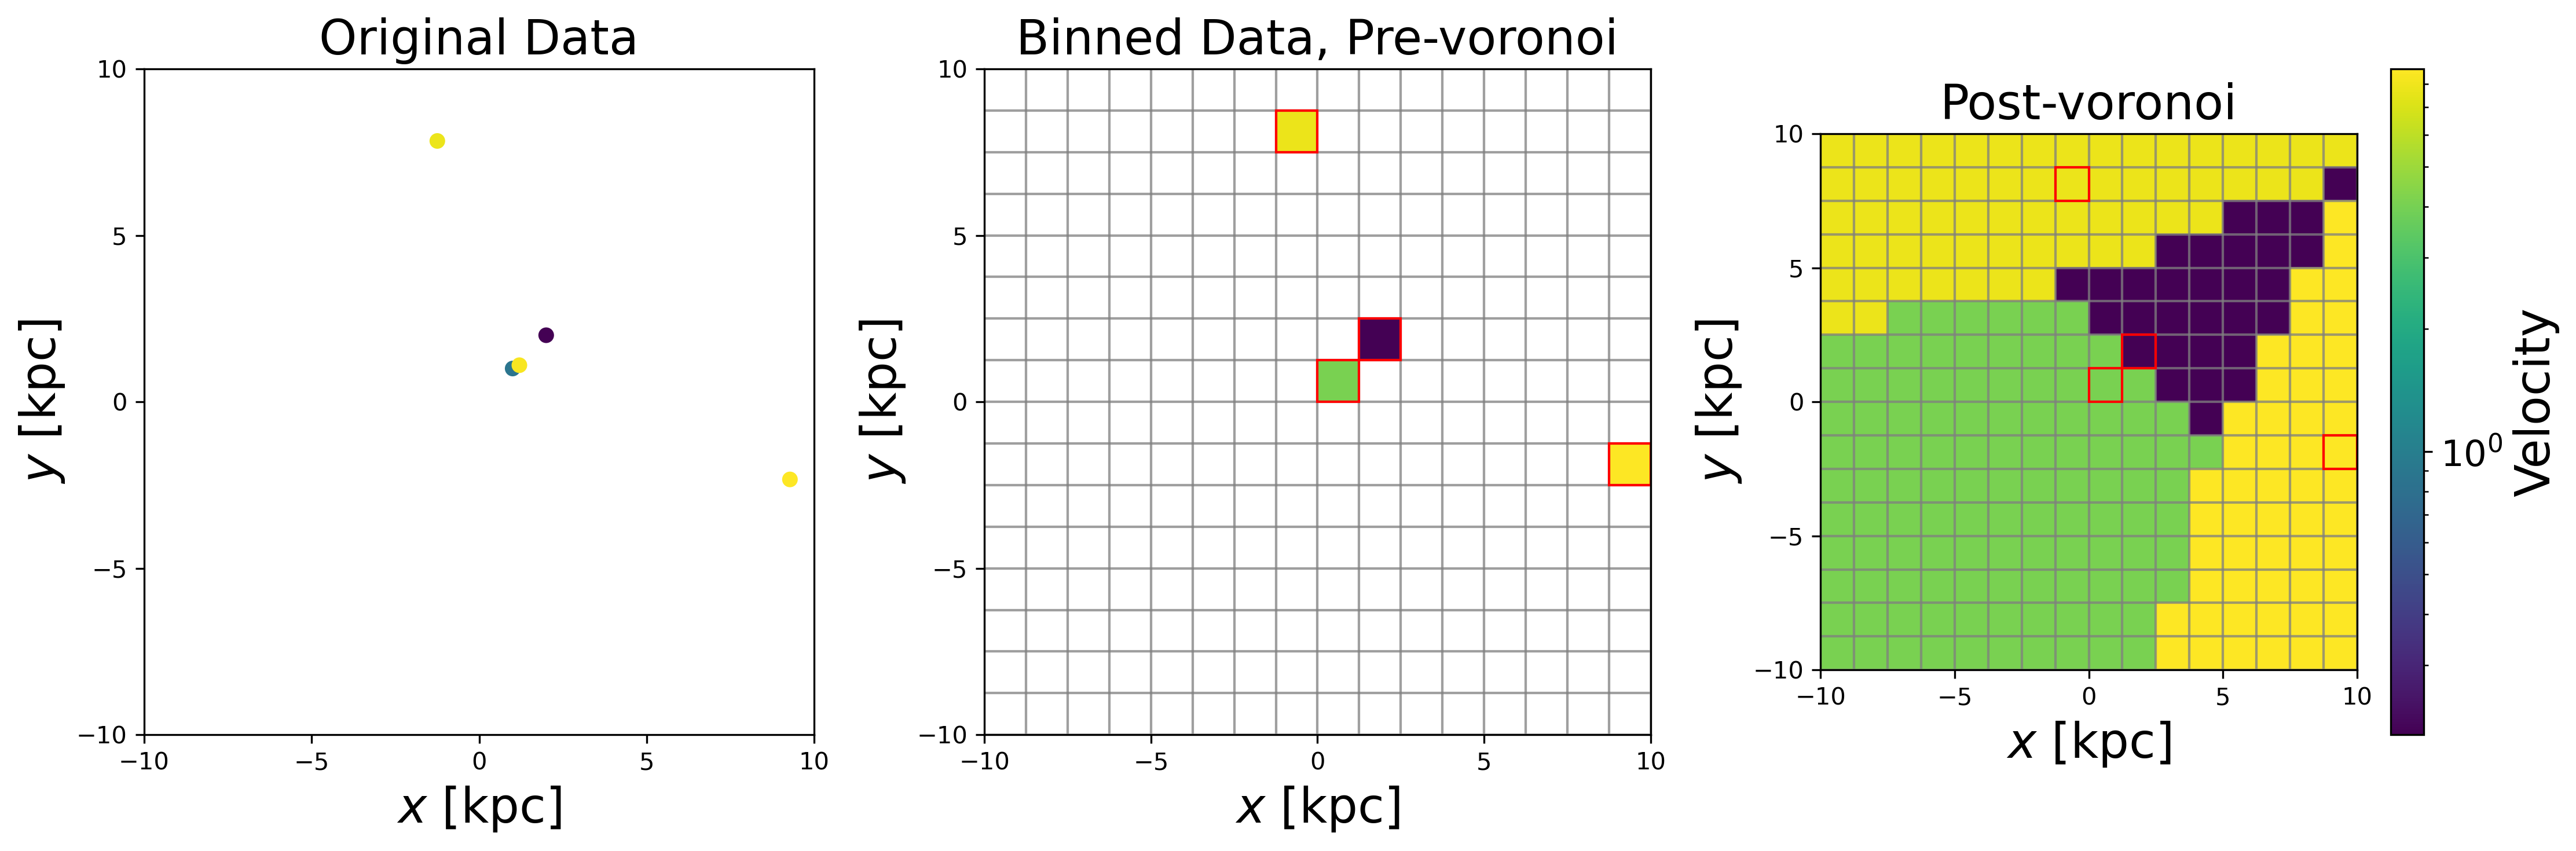

In [61]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

# Subplot 1: Original Data
sc = axs[0].scatter(points[:, 0], points[:, 1], c=velocities, cmap='viridis', s=30, norm=matplotlib.colors.LogNorm())
# cbar = plt.colorbar(sc, ax=axs[0])
axs[0].set_title("Original Data", size=20)
axs[0].set_xlabel('$x$ [kpc]', size=20)
axs[0].set_ylabel('$y$ [kpc]', size=20)
axs[0].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[0].set_yticks(np.array([-10, -5, 0, 5, 10]))
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label("Mass", fontsize=20)

# Subplot 2: Binned Data, Pre-voronoi
axs[1].imshow(binned_points.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[1].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[1].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
axs[1].set_title("Binned Data, Pre-voronoi", size=20)
axs[1].set_xlabel('$x$ [kpc]', size=20)
axs[1].set_ylabel('$y$ [kpc]', size=20)
axs[1].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[1].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Subplot 3: Post-voronoi
im = axs[2].imshow(voronoied_result.T, extent=[-10, 10, -10, 10], norm=matplotlib.colors.LogNorm(), origin="lower")
for i in range(len(voxel_vertices)):
    axs[2].fill(voxel_vertices[i][:, 0], voxel_vertices[i][:, 1], edgecolor='black', fill=False, alpha=0.5, c="gray")

for i in range(len(voxel_vertices[select_binned_points])):
    axs[2].fill(voxel_vertices[select_binned_points][i][:, 1], voxel_vertices[select_binned_points][i][:, 0],
                edgecolor='black', fill=False, alpha=1, c="red")
cbar = plt.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Velocity", fontsize=20)
axs[2].set_title("Post-voronoi", size=20)
axs[2].set_xlabel('$x$ [kpc]', size=20)
axs[2].set_ylabel('$y$ [kpc]', size=20)
axs[2].set_xticks(np.array([-10, -5, 0, 5, 10]))
axs[2].set_yticks(np.array([-10, -5, 0, 5, 10]))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

For the two points in the same cell, we do the following:
$$v_{\text{AVG, } \text{VOX}_i} = \frac{v_1 m_1 + v_2 m_2}{m_1 + m_2}$$
The numerator is obtained using `binned_statistic_dd`

In [60]:
points

array([[ 1.        ,  1.        ],
       [ 2.        ,  2.        ],
       [ 1.2       ,  1.1       ],
       [-1.24825577,  7.83546002],
       [ 9.27325521, -2.33116962]])